# Convolutional Neural Networks

Let's adapt the model we've built yesterday with convolutional layers instead of fully connected ones.

## Recap

As a first simple model, we have implemented a neural network performing softmax regression, which is a straightforward way to do classification. It looked like this:

![alt text](images/softmax-regression-scalargraph.png "Softmax Regression graph")

Then, we expanded the model to include a hidden layer, and tried to look at our model from a _flowing tensors_ perspective.

![alt text](images/fc.png "The flow of tensors")

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np 

BATCH_SIZE = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
image1 = mnist.test.images[0]

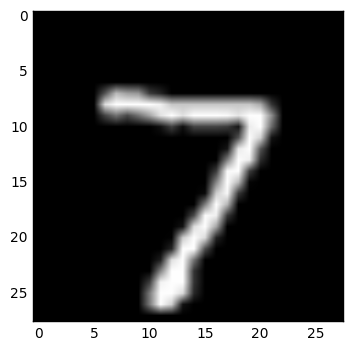

In [7]:
image_plot = np.reshape(image1, [28, 28])

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(image_plot, cmap='gray')

In [8]:
import tensorflow as tf
import numpy as np
def conv_weights(filters_size, channels_size, name):
    shape = filters_size + channels_size
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

def conv(x, W, stride, name):
    strides_shape = [1, stride, stride, 1]
    return tf.nn.conv2d(x, W, strides_shape, padding='SAME', name=name)

def pool(x, size, stride, name):
    pool_shape = [1] + size + [1]
    strides_shape = [1, stride, stride, 1]
    return tf.nn.max_pool(x, pool_shape, strides_shape, padding='SAME', name=name)

TensorFlow `conv2d` function requires the weights to be structured in a 4D tensor with dimension `[filter_width, filter_height, channel_in, channel_out]`, where:

- `filter_width` and `filter_height` represent the dimension of our convolutional filters
- `channel_in` represents the input channel size, be it 1 of grayscale, 3 for RGB, or any other number
- `channel_out` can be seen as the number of filters we are applying to our input, or as the number of feature maps we'll generate as output

`conv2d` also requires the input to be a 4D tensor with dimension `[batch_size, input_height, input_width, channel_in]`.

The strides vector required by `conv2d` is a 4-integer list, mapping each stride to each input dimension (`[batch_size, input_height, input_width, channel_in]`). Since the stride makes sense only when applied to the height and weight of your input, not to the batch or channel dimensions, it will (almost?) always found as `[1, stride, stride, 1]`.

![alt text](images/convolution.png "Convolution")

In [9]:
x = tf.placeholder(tf.float32, [None, 28 * 28], name='input_images')
y_ = tf.placeholder(tf.float32, [None, 10], name='labels')
input_images = tf.reshape(x, [-1, 28, 28, 1])

As usual, we define a placeholder for the variables that we will dynamically feed during the computation. 
These are the input images, that we will pass in form of batches of images (according to the stochastic gradient descent technique), and their relative labels. 
Notice that at first the shape of each image is unidimensional, the 28 * 28 = 784 pixels are taken as a single vector when defining x. 
But then we need to reshape them into a bidimensional matrix. That's because convolutional neural network are based on squared filters, that move onto a squared matrix.
The -1 reshape parameter tells that the the batch_size remains unchanged during the reshaping, while the last parameter says that the input channel is 1. It would have been 3, for instance, for RGB images.

In [10]:
W1 = conv_weights([3, 3], [1, 32], 'L1_weights')
b1 = tf.Variable(tf.constant(0.1, shape=[32]), name='L1_biases')
c1 = conv(input_images, W1, stride=2, name='L1_conv')
h1 = tf.nn.relu(tf.nn.bias_add(c1, b1), name='L1_ReLU')
p1 = pool(h1, size=[2, 2], stride=2, name='L1_pool')

tf.summary.image('input', input_images)
tf.summary.histogram('L1_weights', W1)


<tf.Tensor 'L1_weights_1:0' shape=() dtype=string>

Let's create the first layer of our network. We choose a quite small filter size (3 * 3), since the problem is relatively easy. 
As a rule of thumb for harder problems, more hidden layers with smaller filter size perform equally or better than less hidden layers with bigger filter size. This becuase the combination of smaller filters is able to cover patterns which are larger  than the dimension of the filters themselves. 
As always, we give a name to each step of the computation graph. This is useful for some tasks, like saving/retrieving a specific part of the network.
Notice that both convolution and maxpooling has a stride of 2, so for each step there is a reduction of a factor of 2 in the image size, from 28 * 28 to 14 * 14 and then 7 * 7. Meanwhile, the number of channels switch from 1 to 32. This explain the dimensionality of the right side of the next layer.

In addition to the convolutional operations, here we introduce a maxpool layer and a ReLu layer. 

In [11]:
W2 = tf.Variable(tf.truncated_normal([7 * 7 * 32, 10], stddev=1 / math.sqrt(7 * 7 * 32)), name='L2_weights')
b2 = tf.Variable(tf.constant(0.1, shape=[10]), name='L2_biases')
p1_flat = tf.reshape(p1, [-1, 7 * 7 * 32])

In [12]:
logits = tf.matmul(p1_flat, W2) + b2
y = tf.nn.softmax(logits, name='softmax')

tf.summary.histogram('L2_weights', W2)
tf.summary.histogram('logits', logits)
tf.summary.histogram('output', y)

<tf.Tensor 'output:0' shape=() dtype=string>

In [13]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]), name='cross_entropy')
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
tf.summary.scalar('loss', cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='train_accuracy')
tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
merged_summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter('./summary/conv', sess.graph)
sess.run(init)


In [14]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    _, summary = sess.run([train_step, merged_summaries], feed_dict={x: batch_xs, y_: batch_ys})
    summary_writer.add_summary(summary, i)

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9716


In [18]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [16]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

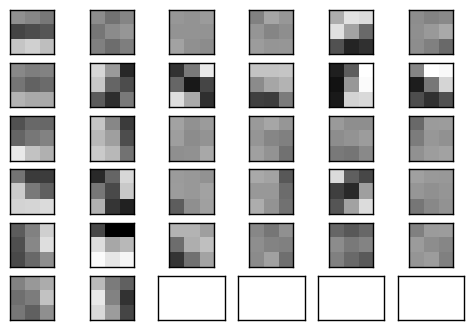

In [19]:
plot_conv_weights(weights=W1)

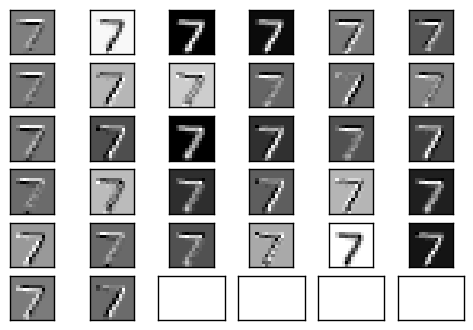

In [20]:
plot_conv_layer(layer=c1, image=image1)


In [21]:
sess.close()

# Exercise 1

Let's build a convolutional neural network designed as follows:
- Convolutional layer with 32 3x3 filters, stride equal to 1 and 2x2 2-strided pool and ReLU activation
- Convolutional layer with 64 3x3 filters, stride equal to 1 and 2x2 2-strided pool and ReLU activation
- Fully-connected layer with 1024 neurons, with ReLU activation with dropout (keep_prob equal to 0.5)
- Fully-connected layer with 10 neurons, with softmax activation

Use GradientDescentOptimizer with learning rate equal to 0.1 for 100 iterations, and a batch size equal to 100.